This code performs some simple data analysis on some eEDM data and creates an asymmetry plot.

In [6]:
import sys
sys.path.insert(0, './code')
sys.path.insert(0,'../Statistics/code')

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib
import seaborn as sns
import numpy as np
import pandas as pd
import os
sns.set_style('white')
sns.set_context('notebook', font_scale=1.3)
mpl.rcParams['axes.linewidth'] = 1

import sympy

from analysis_settings import settings
from analysis import plot_trace, find_data_files, Trace, State, StroboscopicAnalysis
from statfunctions import NonLinearFit1D, regression_plot

Import some data from run 400, block 3:

In [3]:
files = find_data_files('.', run=400, block=[3])
files.head()

,Date,Run,Block,Trace,BinaryPath,HeaderPath
0,2013-06-04,400,3,192,.\data\20130604.0400.0003.000192.01.bin,.\data\20130604.0400.0003.000192.01.header.txt
1,2013-06-04,400,3,191,.\data\20130604.0400.0003.000191.01.bin,.\data\20130604.0400.0003.000191.01.header.txt
2,2013-06-04,400,3,190,.\data\20130604.0400.0003.000190.01.bin,.\data\20130604.0400.0003.000190.01.header.txt
3,2013-06-04,400,3,189,.\data\20130604.0400.0003.000189.01.bin,.\data\20130604.0400.0003.000189.01.header.txt
4,2013-06-04,400,3,188,.\data\20130604.0400.0003.000188.01.bin,.\data\20130604.0400.0003.000188.01.header.txt


Perform the state by state asymmetry analysis with respect to $\tilde{\mathcal{N}}, \tilde{\mathcal{E}}, \tilde{\mathcal{B}}, \tilde{\theta}$. For the purpose of obtaining an averaged polarization switching waveform from a single block with the correct asymmetry, perform the same analysis for just the $\tilde{\mathcal{B}}, \tilde{\theta}$ switches.

In [4]:
traces = [Trace(files.T[i]) for i in range(len(files))]

e_field = lambda header : (np.sign(header['e_field_east_set']) * 
                           np.sign(header['e_field_lead_set']))
e_field.func_name = 'e_field'

b_field = lambda header : (np.sign(header['main_b_coil_curr_east']))
b_field.func_name = 'b_field'

parameters = ['h_state_omega_doublet',
              e_field,
              'probe_angle_abs',
              b_field,
]

settings.asymm_grouping = 18
states = State.create_states_by_parameters(traces, parameters)
state = states[2]
superstates = State.create_states_by_parameters(traces, ['probe_angle_abs', b_field])
superstate = superstates[1]

This is a messy script to create the asymmetry plot. I could package this together for re-use within the `State` object if I wanted to at some point.

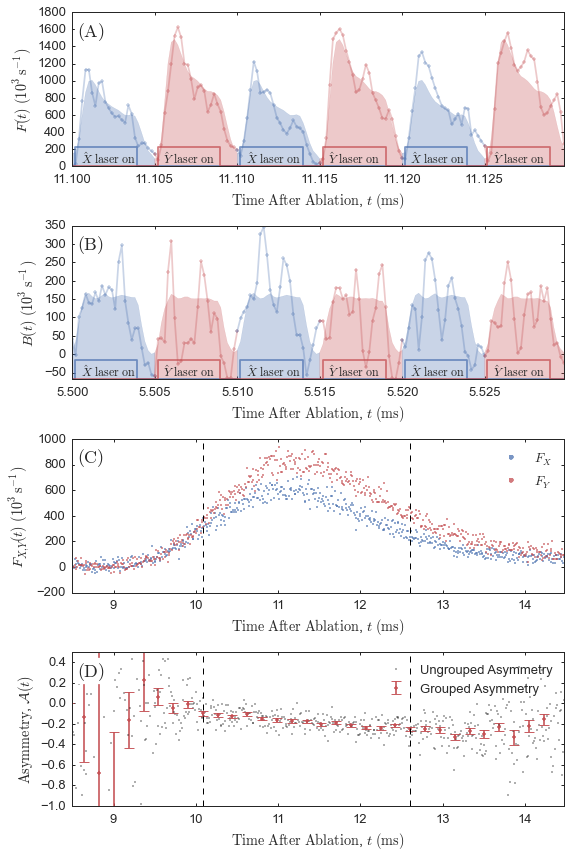

In [8]:
def restore_ticks(string):
    """
    function that adds a label *string* to the upper left of a subplot
    and restores the major ticks on the plot that point inward
    """
    plt.gca().annotate('$(\\mathrm{' + string + '})$', xy=(.01, 1.00 - .05), 
                       xycoords='axes fraction', 
                       annotation_clip=False,
                       fontsize=18,
                       va = 'top',
                       backgroundcolor='w')
    
    plt.tick_params(
    axis='both',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom='on',      # ticks along the bottom edge are off
    top='on',         # ticks along the top edge are off
    labelbottom='on',
    length = 3,
    width  = 1,
    direction='in') # labels along the bottom edge are off

# create the figure with a specific dimension:
plt.figure(figsize=(8,12))

# select the seaborn standard red and blue colors:
colors = sns.color_palette()
colors = [colors[0], colors[2]]

# create an x axis formatter that will not subtract off the offset time
x_formatter = matplotlib.ticker.ScalarFormatter(useOffset=False)

# here is the common xlabel for all of the plots (rendered in latex math-mode roman font)
xlabel = '$\\mathrm{Time}$ $\\mathrm{After}$ $\\mathrm{Ablation}$, $t$ $(\\mathrm{ms})$'

##### FLUORESCENCE SUBPLOT ########
plt.subplot(4,1,1)

index = 28000 # time index at which to plot
width = 150   # with in number of time indices to plot
p = 25        # manually inputting the number of points in a single polarization bin

s = np.sum(state.trace, axis=(3))       # sum over PMT index
s0 = np.sum(superstate.trace, axis=(3))
s0 = np.mean(s0, axis=0)                # average over time after ablation index

s = np.reshape(s, (np.prod(s.shape)))   # reshape s to unseparate polarizations
s0 = np.reshape(s0, (np.prod(s0.shape)))

s0 = np.array(list(s0) * (width//(p*2))) # repeat the averaged waveform for the number of shown cycles

s = s[index:index + width]              # pick out the desired time after ablation window
s0 = s0 * np.sum(s)/np.sum(s0)          # fit the amplitude of the averaged waveform to the window region we are looking at
t  = state.t_ablation[index//(p * 2)] + np.arange(len(s0)) * state.header['dt'][0] * 10**3 # get time series
offset = .0002
t_det = np.linspace(min(t), max(t), 500)

# create the digital polarization switching waveforms
X = np.logical_and(
          (t_det - min(t_det)) % .01 > offset,
          (t_det - min(t_det)) % .01 <= .0038 + offset )
Y = np.logical_and(
          (t_det - min(t_det)) % .01 > offset + .005,
          (t_det - min(t_det)) % .01 <= .0038 + offset + .005 )

labels= ['$\hat{X}$ $\\mathrm{laser}$ $\\mathrm{on}$',
         '$\hat{Y}$ $\\mathrm{laser}$ $\\mathrm{on}$']

# plot the raw data and the averaged waveforms
for i in range(width//p):
    if i == width//p - 1:
        sl = slice(p*i, p*(i + 1))
    else:
        sl = slice(p*i, p*(i + 1) + 1)
    plt.fill_between(t[sl], s0[sl]/10**3, alpha=.3, color=colors[i%len(colors)])
    plt.plot(t[sl], s[sl]/10**3, '.-', color=colors[i%len(colors)], alpha=.3)
    
    
plt.xlim([min(t), max(t)])
plt.ylim([0, plt.gca().get_ylim()[-1]])
plt.xlabel(xlabel)

# plot the text labels for the digital waveform
ylim = plt.gca().get_ylim()
for i in range(width//p):
    if i == width//p - 1:
        sl = slice(p*i, p*(i + 1))
    else:
        sl = slice(p*i, p*(i + 1) + 1)
    plt.text(t[p*i] + .0005, (ylim[1] - ylim[0])/50.0 + ylim[0], labels[i%len(labels)],
             fontsize=12)
    
# plot the digital waveforms
plt.step(t_det, X * (ylim[1] - ylim[0])/8.0 + ylim[0],
         color=colors[0], alpha=.75)
plt.step(t_det, Y * (ylim[1] - ylim[0])/8.0 + ylim[0],
         color=colors[1], alpha=.75)

plt.gca().xaxis.set_major_formatter(x_formatter)
plt.ylabel('$F(t)$ $(10^3 \\mathrm{s}^{-1})$')
restore_ticks('A') # add the label "A"

##### BACKGROUND SUBPLOT ##########
plt.subplot(4,1,2)

index = 0

s = np.sum(state.trace, axis=(3))
s0 = np.sum(superstate.background, axis=(3))
s = np.reshape(s, (np.prod(s.shape)))

s0 = np.reshape(s0, (np.prod(s0.shape)))
s0 = np.array(list(s0) * (width//(p*2)))

s0 = s0 - min(s0)
s = s[index:index + width] + s0

t  = state.t_ablation[index//(p * 2)] + np.arange(len(s0)) * state.header['dt'][0] * 10**3
t_chop = (t - min(t)) % .005 < .0038

for i in range(width//p):
    if i == width//p - 1:
        sl = slice(p*i, p*(i + 1))
    else:
        sl = slice(p*i, p*(i + 1) + 1)
    plt.fill_between(t[sl], min(s)/10**3, s0[sl]/10**3, alpha=.3, color=colors[i%len(colors)])
    plt.plot(t[sl], s[sl]/10**3, '.-', color=colors[i%len(colors)], alpha=.3)
    
plt.xlim([min(t), max(t)])
plt.ylim([min(s)/10**3, plt.gca().get_ylim()[-1]])
plt.gca().xaxis.set_major_formatter(x_formatter)

ylim = plt.gca().get_ylim()

for i in range(width//p):
    if i == width//p - 1:
        sl = slice(p*i, p*(i + 1))
    else:
        sl = slice(p*i, p*(i + 1) + 1)
    plt.text(t[p*i] + .0005, (ylim[1] - ylim[0])/50.0 + ylim[0], labels[i%len(labels)],
             fontsize=12)

t_det = t_det - min(t_det) + min(t)
plt.step(t_det, X * (ylim[1] - ylim[0])/8.0 + ylim[0],
         color=colors[0], alpha=.75)
plt.step(t_det, Y * (ylim[1] - ylim[0])/8.0 + ylim[0],
         color=colors[1], alpha=.75)

plt.ylabel('$B(t)$ $(10^3\\mathrm{s}^{-1})$')
plt.xlabel(xlabel)
restore_ticks('B')

############ INTEGRATED FLUORESCENCE SUBPLOT ##########
plt.subplot(4,1,3)

threshold = 1.5 * 10**5
above = np.where(np.squeeze(state.binned_signal[:,0] > threshold))
above_times = state.t_binned[above]
time_cut = [min(above_times), max(above_times)]

xlim = [8.5, max(state.t_ablation)]

labels = ['$F_X$', '$F_Y$']

s = np.sum(state.trace, axis=3)
s = np.mean(s, axis=2)
for i in range(2):
    plt.plot(state.t_ablation, s[:,i]/10**3,'.', alpha=.75, 
             color=colors[i%len(colors)], label=labels[i%len(labels)], markersize=4)    
plt.xlim(xlim)
plt.legend(loc='upper right',  markerscale=2.5)
plt.xlabel(xlabel)

ylim = plt.gca().get_ylim()
for t_c in time_cut:
    plt.plot([t_c, t_c], ylim, '--k', linewidth=1)

plt.ylabel('$F_{X,Y}(t)$ $(10^3\\mathrm{s}^{-1})$')
restore_ticks('C')

########## UNGROUPED AND GROUPED ASYMMETRY ############

plt.subplot(4,1,4)
plt.plot(state.t_ablation, state.asymmetry[:,1],'.k', 
         alpha=.4, label='Ungrouped Asymmetry', markersize=4)
(_, caps, _) = plt.errorbar(
                 state.t_binned, 
                 state.binned_asymmetry[:,1],
                 state.dbinned_asymmetry[:,1],
                 fmt='.', color=colors[1], 
                 alpha=.9, capsize=5,
                 label='Grouped Asymmetry')
for cap in caps:
    cap.set_markeredgewidth(1)

plt.ylim([-1,.5])
plt.xlim(xlim)
plt.xlabel(xlabel)
plt.ylabel('$\\mathrm{Asymmetry}$, $\mathcal{A}(t)$')
plt.legend(loc='upper right', markerscale=1.0)

ylim = plt.gca().get_ylim()
for t_c in time_cut:
    plt.plot([t_c, t_c], ylim, '--k', linewidth=1)
restore_ticks('D')

plt.tight_layout()
plt.savefig('fluorescence_background_asymmetry_v2.pdf')